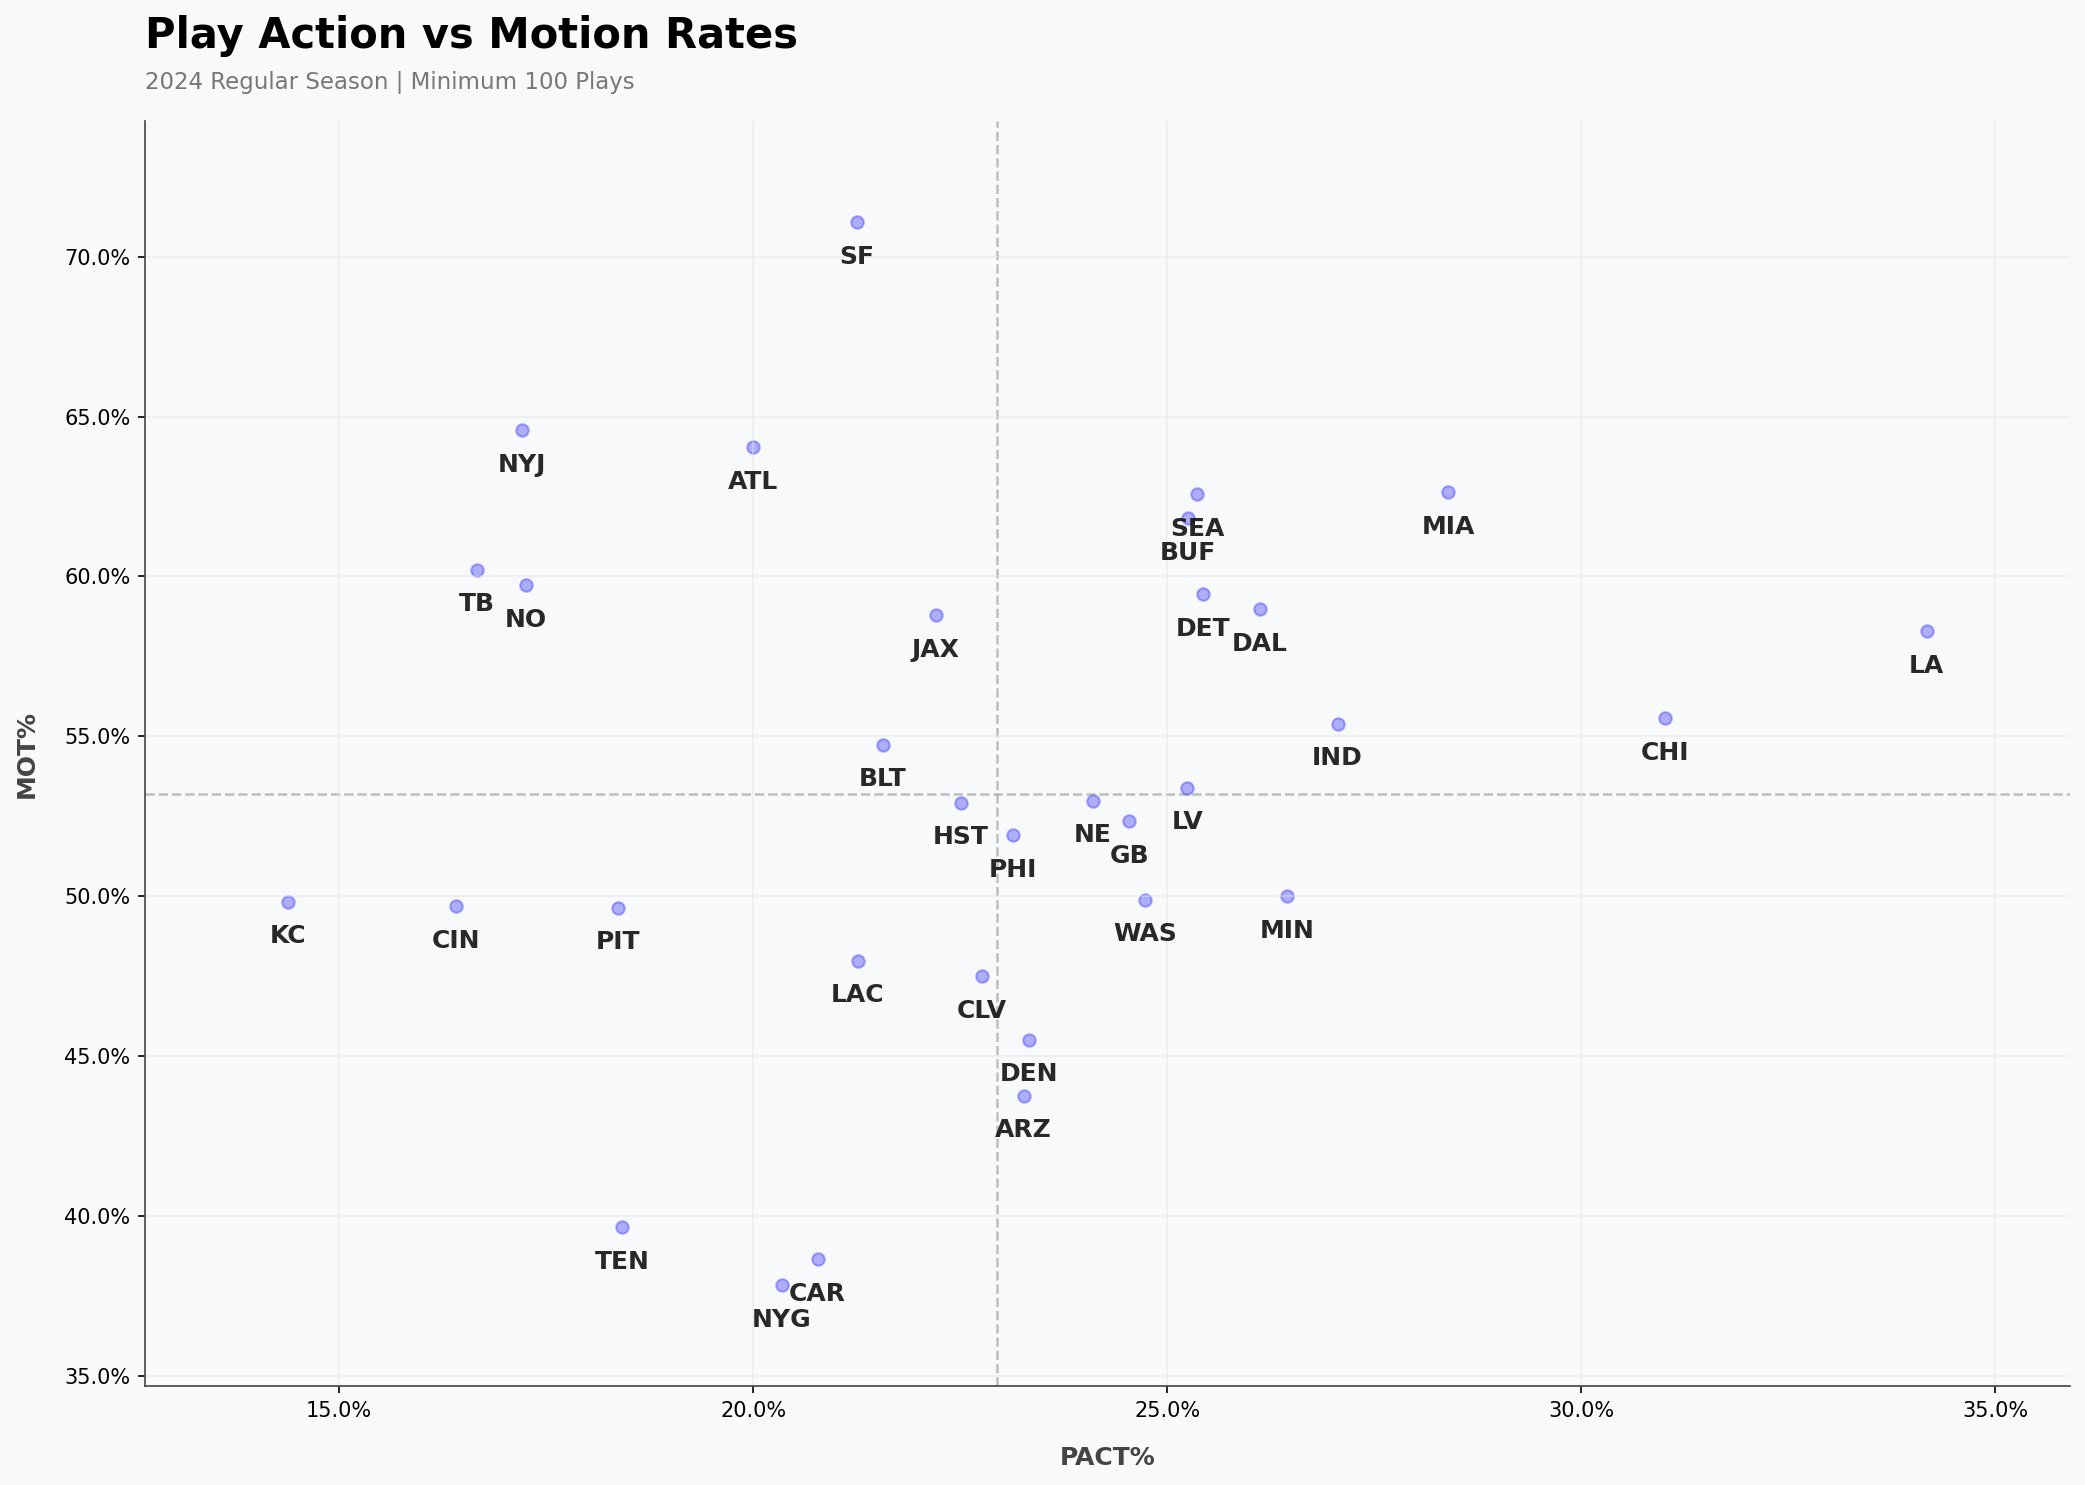

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
from PIL import Image

# 1. Load and Clean Data
# Note: header=1 is used because the first row contains metadata like "BASIC", "TENDENCIES"
df_plot = pd.read_csv('data/offense_tendancies.csv', header=1)

# Convert percentage columns to 0-1 scale to work with PercentFormatter(1)
# The csv has values like 26.1 (for 26.1%), so we divide by 100
df_plot['PACT%'] = df_plot['PACT%'] / 100
df_plot['MOT%'] = df_plot['MOT%'] / 100

x_axis = 'PACT%'
y_axis = 'MOT%'
title = "Play Action vs Motion Rates"

# 2. Styling Constants
BG_COLOR = "#f8f9fa"  # Modern soft grey-white
GRID_COLOR = "#e1e4e8"
AXIS_COLOR = "#444444"
MEAN_LINE_COLOR = "#666666"

# 3. Create Figure
fig, ax = plt.subplots(figsize=(14, 10), dpi=150)
fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)

# 4. Helper for Logos (High-Res PIL Resize)
def getImage(path, zoom_size=40):
    if not os.path.exists(path): return None
    img = Image.open(path).convert("RGBA")
    w, h = img.size
    aspect = h / w
    img = img.resize((zoom_size, int(zoom_size * aspect)), Image.Resampling.LANCZOS)
    return OffsetImage(img, zoom=1.0)

# 5. Plotting
median_x = df_plot[x_axis].median()
median_y = df_plot[y_axis].median()

for i, row in df_plot.iterrows():
    x, y = row[x_axis], row[y_axis]
    
    # TODO: Update this path to where your logos are stored.
    # We use row["Tm"] (e.g., 'DAL', 'SF') to find the file.
    logo_path = f'data/logos/{row["Tm"]}.png'
    
    # Add Logo
    img_obj = getImage(logo_path, zoom_size=38)
    if img_obj:
        ab = AnnotationBbox(img_obj, (x, y), frameon=False, zorder=3)
        ax.add_artist(ab)
    else:
        # Fallback: if no logo is found, plot a point so data is still visible
        ax.scatter(x, y, color='blue', alpha=0.3)
    
    # Add Label (Team Name)
    plt.annotate(row['Tm'], (x, y),
                 xytext=(0, -20), textcoords='offset points', 
                 fontsize=12, fontweight='bold', color='#111111',
                 ha='center', alpha=0.9)

# 6. Modern Formatting
# Remove top and right borders (Spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(AXIS_COLOR)
ax.spines['bottom'].set_color(AXIS_COLOR)

# Add a clean, visible grid behind logos
ax.grid(True, linestyle='-', alpha=0.5, color=GRID_COLOR, zorder=0)

# Thick mean lines to create quadrants
ax.axvline(median_x, color=MEAN_LINE_COLOR, linestyle='--', lw=1.2, alpha=0.4, zorder=1)
ax.axhline(median_y, color=MEAN_LINE_COLOR, linestyle='--', lw=1.2, alpha=0.4, zorder=1)

# Labels and Titles
ax.set_xlabel(x_axis, fontsize=12, fontweight='bold', color=AXIS_COLOR, labelpad=12)
ax.set_ylabel(y_axis, fontsize=12, fontweight='bold', color=AXIS_COLOR, labelpad=12)

# Left-aligned bold title + subtitle
plt.title(title, fontsize=20, fontweight='black', loc='left', pad=35)
ax.text(0, 1.025, '2024 Regular Season | Minimum 100 Plays', transform=ax.transAxes, 
        fontsize=11, color='#777777', ha='left')

# Axis Formatting
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.xaxis.set_major_formatter(PercentFormatter(1))

# Set generous limits so logos aren't cut off
margin_x = df_plot[x_axis].std() * 0.4
margin_y = df_plot[y_axis].std() * 0.4
ax.set_xlim(df_plot[x_axis].min() - margin_x, df_plot[x_axis].max() + margin_x)
ax.set_ylim(df_plot[y_axis].min() - margin_y, df_plot[y_axis].max() + margin_y)

plt.tight_layout()
plt.show()